In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import warnings
import logging
import math

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/ANN&DL_Homework2
#!unzip training_dataset_homework2.zip

/content/drive/MyDrive/ANN&DL_Homework2


In [9]:
# Load the dataset
X =  np.load('x_train.npy')
Y = np.load('y_train.npy')

In [10]:
X.shape, Y.shape

((2429, 36, 6), (2429,))

In [11]:
n_classes = len(np.unique(Y))
class_labels = np.unique(Y)
print("There are {} classes".format(n_classes))
print("The labels are: {}".format(class_labels))

There are 12 classes
The labels are: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [12]:
# Count the number of samples in each class
class_labels_count = []
for label in class_labels:
  class_labels_count.append(sum([1 if Y[i]==label else 0 for i in range(Y.shape[0])]))

for i in range(len(class_labels)):
  print("For label {} there are {} samples".format(class_labels[i], class_labels_count[i]))

For label 0 there are 34 samples
For label 1 there are 123 samples
For label 2 there are 270 samples
For label 3 there are 381 samples
For label 4 there are 62 samples
For label 5 there are 153 samples
For label 6 there are 313 samples
For label 7 there are 68 samples
For label 8 there are 120 samples
For label 9 there are 777 samples
For label 10 there are 77 samples
For label 11 there are 51 samples


In [13]:
def plot_features(x, y, x2=None):
  fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
  fig.suptitle('Showing the features of label {}'.format(y), fontsize=10)
  for i in range(x.shape[1]):
    ax[i//3, i%3].plot(x[:,i], 'o--', label='original feature', color='blue')
    if x2 is not None:
      ax2 = ax[i//3, i%3].twinx()
      ax2.plot(x2[:,i], 'o:', label='normalized feature', color='orange')
    ax[i//3, i%3].set_title('feature {}'.format(str(i)))
    ax[i//3, i%3].legend()
  plt.show()

In [14]:
# Cum sum is the variable with the starting position of each class
cum_sum = np.cumsum(np.array(class_labels_count))
cum_sum = np.roll(cum_sum,1)
cum_sum[0] = 0
cum_sum

array([   0,   34,  157,  427,  808,  870, 1023, 1336, 1404, 1524, 2301,
       2378])

In [ ]:
for elem in cum_sum:
  plot_features(X[elem], Y[elem])

In [16]:
from sklearn.model_selection import train_test_split

# Split the data in train,val and test set
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=seed, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, shuffle=True, random_state=seed, stratify=Y_train_val)

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape,Y_test.shape

((1967, 36, 6), (219, 36, 6), (243, 36, 6), (1967,), (219,), (243,))

In [17]:
# Unroll the training set in order to compute the mean and the std of each feature
X_unrolled = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], X_train.shape[2]))
print(X.shape, X_unrolled.shape)

X_mean = np.mean(X_unrolled, axis=0)
X_std = np.std(X_unrolled, axis=0)

(2429, 36, 6) (70812, 6)


In [18]:
X_mean.shape, X_std.shape

((6,), (6,))

In [19]:
print(X_mean)
print(X_std)

[ 8.4409552  11.1070953  21.23054996 27.24076344 30.41101099 26.90711497]
[253.58240631 777.2715952  722.72048578 700.70644352 679.74291031
 712.47014922]


In [20]:
# Apply the Z-score normalization
for i in tqdm(range(X_train.shape[0])):
  X_train[i,:,:6] = (X_train[i,:,:6] - X_mean) / X_std
for i in tqdm(range(X_val.shape[0])):
  X_val[i,:,:6] = (X_val[i,:,:6] - X_mean) / X_std
for i in tqdm(range(X_test.shape[0])):
  X_test[i,:,:6] = (X_test[i,:,:6] - X_mean) / X_std

X_train.shape, X_val.shape, X_test.shape

100%|██████████| 243/243 [00:00<00:00, 160708.90it/s]


((1967, 36, 6), (219, 36, 6), (243, 36, 6))

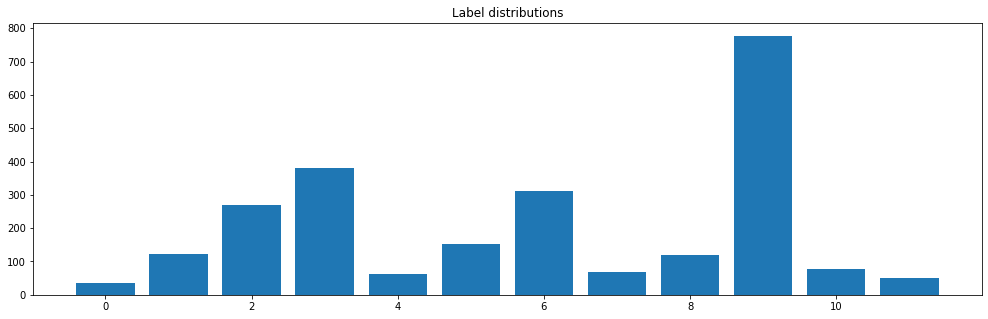

In [21]:
# Inspect label distribution
plt.figure(figsize=(17,5))
plt.bar(x=class_labels, height=class_labels_count)
plt.title('Label distributions')
plt.show()

In [22]:
# Convert the sparse labels to categorical values
Y_train = tfk.utils.to_categorical(Y_train)
Y_val = tfk.utils.to_categorical(Y_val)
Y_test = tfk.utils.to_categorical(Y_test)

Y_train.shape, Y_val.shape, Y_test.shape

((1967, 12), (219, 12), (243, 12))

In [23]:
def build_network(input_shape, classes):

  # Build the neural network layer by layer
  input_layer = tfkl.Input(shape=input_shape, name='Input')

  # Feature extractor
  cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
  cnn = tfkl.Dropout(.1, seed=seed)(cnn)
  cnn = tfkl.MaxPooling1D()(cnn)
  cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn) 
  cnn = tfkl.Dropout(.15, seed=seed)(cnn) 
  cnn = tfkl.MaxPooling1D()(cnn)
  cnn = tfkl.Conv1D(1024,3,padding='same',activation='relu')(cnn)  
  cnn = tfkl.Dropout(.2, seed=seed)(cnn)
  cnn = tfkl.MaxPooling1D()(cnn)
  cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)  
  cnn = tfkl.Dropout(.25, seed=seed)(cnn)
  cnn = tfkl.MaxPooling1D()(cnn)
  cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
  gap = tfkl.GlobalAveragePooling1D()(cnn)
  dropout = tfkl.Dropout(.3, seed=seed)(gap)

  # Classifier
  classifier = tfkl.Dense(32, activation='relu')(dropout)
  output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

  # Return the model
  return model

In [30]:
# Defaining the training params
input_shape = X_train.shape[1:]
classes = Y_train.shape[-1]
batch_size = 64
epochs = 200

# Build the model
model = build_network(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 36, 128)           2432      
                                                                 
 dropout_5 (Dropout)         (None, 36, 128)           0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 18, 128)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 18, 256)           98560     
                                                                 
 dropout_6 (Dropout)         (None, 18, 256)           0         
                                                             

In [31]:
# Train the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    # class_weight=class_weight,
    validation_data=(X_val, Y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 1s 19ms/step - loss: 2.2205 - accuracy: 0.3050 - val_loss: 2.0811 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 10ms/step - loss: 1.9693 - accuracy: 0.3574 - val_loss: 1.9706 - val_accuracy: 0.3699 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 1.9101 - accuracy: 0.3660 - val_loss: 2.0059 - val_accuracy: 0.3653 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 9ms/step - loss: 1.8260 - accuracy: 0.3976 - val_loss: 1.9068 - val_accuracy: 0.3744 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 1.7527 - accuracy: 0.4174 - val_loss: 1.7831 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 9ms/step - loss: 1.6724 - accuracy: 0.4423 - val_loss: 1.7428 - val_accuracy: 0.4977 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 9ms/step - loss: 1

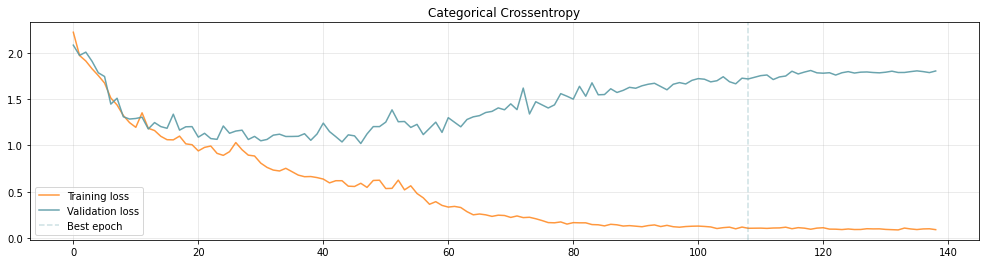

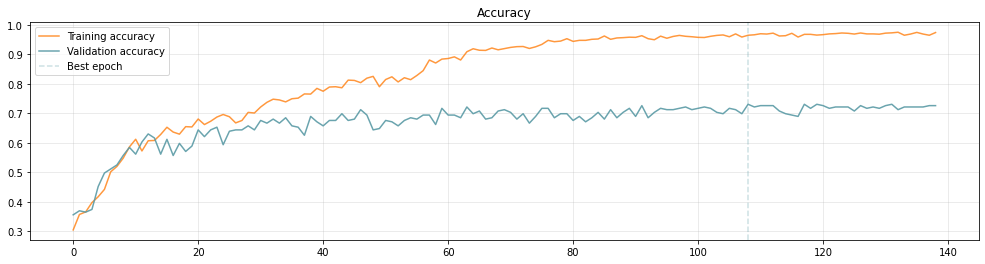

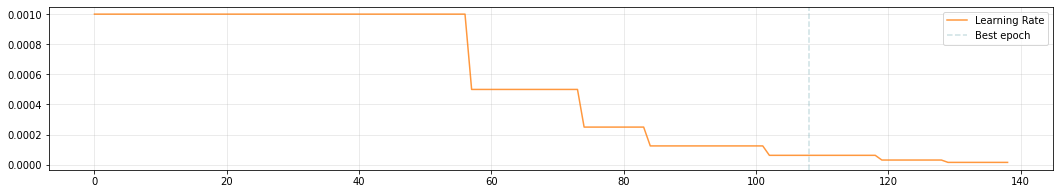

In [32]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [33]:
# Compute the prediction on the test set
predictions = model.predict(X_test)
predictions.shape

8/8 [==============================] - 0s 4ms/step


(243, 12)

Accuracy: 0.679
Precision: 0.6529
Recall: 0.5746
F1: 0.5952


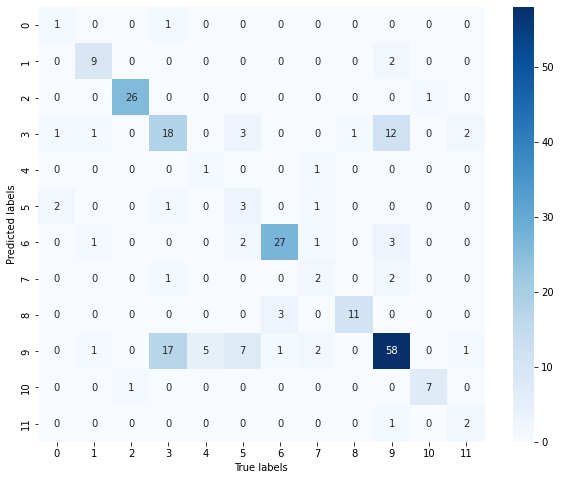

In [34]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', annot=True, xticklabels=list(class_labels), yticklabels=list(class_labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Save the model
#model.save('Conv1D_model')
'''
Mean: [8.4409552  11.1070953  21.23054996 27.24076344 30.41101099 26.90711497]
Std: [253.58240631 777.2715952  722.72048578 700.70644352 679.74291031 712.47014922]
'''